# Lab 1 - Measuring Galactic Dust using RR Lyrae stars

## Abstract
In this report, we will derive a dustmap of the Milky Way, using RR Lyrae stars as standard candles. The period-magnitude relation of a set of accurately measured, low extinction stars, will be chosen as a baseline for the intrinsic extinction. The period-magnitude relation is then derived using mcmc sampling, with an uninformed prior. Finally, the calculated extinctions of ~30'000 RR Lyrae stars will be used to create a dustmap of the Milky Way. In the end, we compare the map to other, more complete maps. The comparison shows the same general layout, although our map is somewhat lacking in detail, especially on, and far from, the galactic disk.

# 1. Introduction
## 1.1 RR Lyrae Stars
RR Lyrae type stars is a class of variable stars, named after the first discovered star of it's type, also named RR Lyrae.

Due to their location on the instability strip of the HR-diagram, RR Lyrae stars oscillate their magnitude at all frequencies with a period of around half a day. The period of these oscillations is related to their visual magnitude. They are therefore commonly used at standard candles, due to our ability to predict their period-magnitude relationship.

## 1.2 Extinction 
Extinction is the term for blocking of radiation by dust particles, and therefore reduction in apparent magnitude of stellar objects. The extinction for a given object on the night sky can be defined as the difference between the "actual"(intrinsic) color magnitude of an object if there were no dust, and its observed color magnitude. By creating a model for the intrinsic color of a RR Lyrae star, and comparing it to confirmed catalog values, we can create an extinction map, and by extension a dustmap of our galaxy.

# 2. Reproducing RR Lyrae period data
The period of each RR Lyrae star is provided for us in the ```gaiadr2.vari_rrlyrae``` catalog. We will start by attempting to reproduce some of these periods, using the raw magnitude/time data for each object. We begin by fetching a hundred random stars from the catalog.

In [1]:
from astropy.stats import LombScargle
import scipy
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astroquery.utils.tap.core
import pandas
from astroquery.utils.tap.core import TapPlus
import warnings
import seaborn as sns
from scipy.stats import kde

warnings.filterwarnings('ignore')

%matplotlib inline
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'Large'
mpl.rcParams['figure.titlesize'] = 'medium'

gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
ADQL_query="""
SELECT
    TOP 100 *
FROM
    gaiadr2.vari_rrlyrae
WHERE
    NOT pf = 'NaN'"""

job = gaia.launch_job_async(ADQL_query)
data = job.get_results()
data = data.to_pandas()

Query finished.


## 2.1 Fetching magnitude data with DataLink
Storing magnitude over time data for each celestial object is cumbersome in a database, especially since each object can contain a very different number of magnitude observations. Gaia has established a DataLink service for fetching such data. The service requires the object's ```source_id```, which is provided for all observed objects in GDR2, and returns a ```XML``` file with binary data about magnitudes over time.

I found the simplest way to access the service was to copy the download link provided in their [tutorial](http://gea.esac.esa.int/archive-help/index.html), and append each source_id in turn in a loop. In the URL, we can specify csv file format using the ```FORMAT=CSV``` key. Pandas happens to have a great method, ```pandas.read_csv(URL)```, which simply takes a URL linking to a CSV file as argument, and returns a pandas DataFrame object with all the data.

In the URL, we will also filter for G-band (as the data also contains RP and BP) using the ```BAND=G``` key. 

The code is shown below. It also further reads the data from the DataFrame object into two arrays. Since the number of observations vary, we overestimate the number of observations, and use NaN values for "no more observation". The precence of NaN values will be taken into consideration throughout the code.

In [3]:
source_ids = np.array(data['source_id'], dtype="str")

url_raw = r"""http://geadata.esac.esa.int/data-server/data?RETRIEVAL_TYPE=epoch_photometry&FORMAT=CSV&BAND=G&ID="""

N = len(source_ids)
n = 100 # Overestimate of number of observations.
photometry = np.zeros((N,2,n))  # Array of N objects, with source_id, time and mag data. I.e, [5,0,:] holds object 5's time data.
photometry[:] = np.nan  # Since the number of observations vary, we will fill the empty array-spots with NaN's, and discard them later.
photometry_lengths = np.zeros(N) # Keeping track of number of observations for each object.
mean_mag = np.zeros(N) # Mean magnitude of each object.
for i, source_id in enumerate(source_ids):
    url = url_raw + source_id
    DataLink_data = pandas.read_csv(url)
    photometry[i,:,:DataLink_data.shape[0]] = DataLink_data[['time','mag']].T
    photometry_lengths[i] = DataLink_data.shape[0]
    mean_mag[i] = np.mean(DataLink_data['mag'])
photometry = photometry[np.argsort(photometry_lengths)[::-1],:,:]  # Sorting by number of observations.
source_ids = source_ids[np.argsort(photometry_lengths)[::-1]]  # Sorting source id's by number of observations.
mean_mag = mean_mag[np.argsort(photometry_lengths)[::-1]]
print(f"The photometry data is now collected and sorted, from the most ({int(np.max(photometry_lengths))}) to the least ({int(np.min(photometry_lengths))}) number of observations.")

The photometry data is now collected and sorted, from the most (59) to the least (12) number of observations.


Now, a little look at our data reveals that the time-spacing between observations is extremely varied. Below we have plotted the times of observations for one star. The first plot shows all measurements, and we can see that distinguishing between the close-lying measurements is impossible at this time-scale. The plot below shows a subset of observations, revealing the high frequency of measurements.

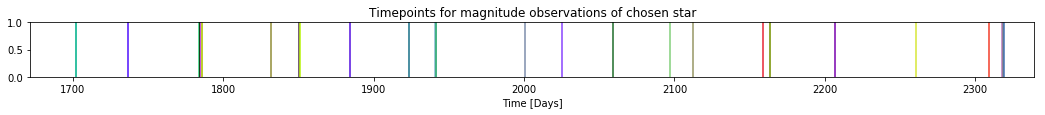

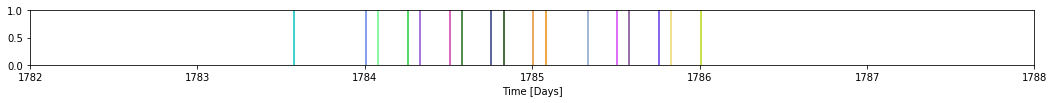

In [4]:
np.random.seed(99)
plt.figure(figsize=(18,1))
for i in range(len(photometry[0,0,:])):
    plt.axvline(x = photometry[0,0,i], c=np.random.rand(3,))
plt.xlabel("Time [Days]"); plt.title("Timepoints for magnitude observations of chosen star")
np.random.seed(99)
plt.figure(figsize=(18,1))
for i in range(len(photometry[0,0,:])):
    plt.axvline(x = photometry[0,0,i], c=np.random.rand(3,))
plt.xlim(1782, 1788); plt.xlabel("Time [Days]");

## 2.2 Lomb-Scargle frequency analysis

Now, we would like to do some period analysis on this, but since the spacing is uneven, Fourier analysis is gonna come up short handed. We will instead employ a Lomb-Scargle diagram, which is suited for frequency analysis of uneven observations. For this, we will use the ```astropy.stats.LombScargle``` package.

In the 100 stars we collected from Gaia, the mean frequency between observations is 0.036, while the maximum is over 4000, a whooping 5 magnitudes larger. However, a quick look reveals that this is only a set of 10 outliers, as we can see from the prints below. The majority of measurements are done with a frequency of either ~13/day, or virtually 0, where the 13/day obviously represents the small "sets" of measurements, while the 0 is the time between sets of measurements.

The mean frequency is 0.036
The maximum frequency in data is 4445.669
The 20 largest frequencies are [4445.66930761 4445.19332503 4445.16022648 4445.14629891 4445.12028154
 4445.07829319 4444.97544168 4444.85928011 4444.83119524 4444.83050345
   13.55434843   13.55429205   13.55428197   13.55428163   13.55424997
   13.55419928   13.55418374   13.55406517   13.55378979   13.55342391]


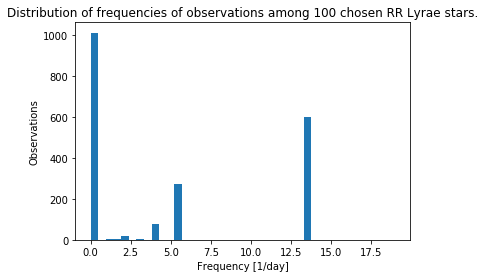

In [5]:
print(f"The mean frequency is {1/np.nanmean(photometry[:,0,1:] - photometry[:,0,:-1]):.3f}")
print(f"The maximum frequency in data is {1/np.nanmin(np.abs(photometry[:,0,1:] - photometry[:,0,:-1])):.3f}")
freqs = 1/np.abs(photometry[:,0,1:] - photometry[:,0,:-1]).flatten()
freqs = freqs[~np.isnan(freqs)]
freqs = np.sort(freqs)[::-1]
print(f"The 20 largest frequencies are {freqs[:20]}")

plt.hist(freqs, bins=40, range=(0, 19))
plt.xlabel("Frequency [1/day]"); plt.ylabel("Observations"); plt.title("Distribution of frequencies of observations among 100 chosen RR Lyrae stars.");

This non-uniformity in frequencies can lead to problems. According to the Lomb-Scargle [documentation](http://docs.astropy.org/en/stable/stats/lombscargle.html) in the ```astropy``` package, the autopower function used assumes no frequency is larger than 5 times the average nyquist frequency. Obviously this is inadequate for our case. Luckily, we can set our own maximum frequency. As observed in figure 4 of [Clementini et al. 2016](https://arxiv.org/abs/1609.04269), virtually all RR Lyrae stars lie within a period span of 0.25 to 1 days, in other words a frequency of 1-4 /day.

Setting this as our frequency boundaries, we can generate some Lomb-Scargle diagrams for our stars. We begin by taking a look at the object with most observations. Below we see it's Lomb-Scargle diagram, as well as it's "best fit" plotted over the two time spans of observations with most data. The fit isn't very convincing, but then again, neither is the peak of the phase diagram. The peak does at least agree with the ```gaiadr2.vari_rrlyrae``` catalog's reported frequency, so there is that.

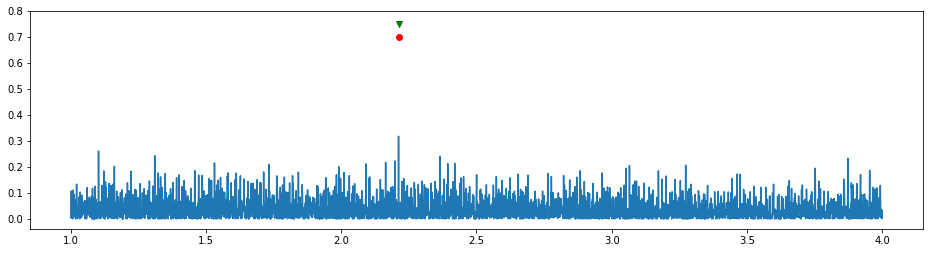

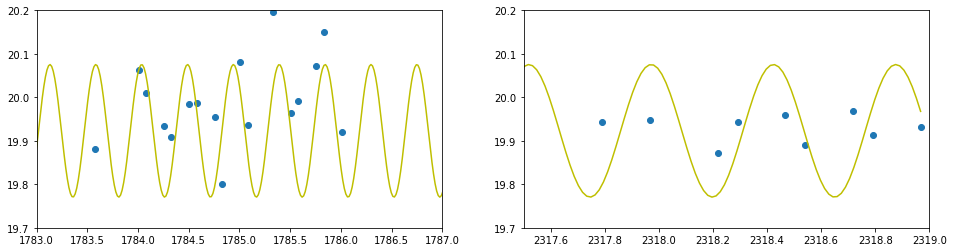

In [6]:
t = photometry[0,0,:]
t = t[~np.isnan(t)]
mag = photometry[0,1,:]
mag = mag[~np.isnan(mag)]
LS = LombScargle(t, mag)
LS_freq, LS_power = LS.autopower(minimum_frequency=1, maximum_frequency=4, samples_per_peak=20)
LS_peak = LS_freq[np.argmax(LS_power)]
Gaia_freq = 1/float((data[data['source_id'] == int(source_ids[0])])['pf'])

plt.figure(figsize=(16,4))
plt.plot(LS_freq, LS_power)
plt.scatter(Gaia_freq, 0.7, c='r', label="Reported")
plt.scatter(LS_peak, 0.75, c='g', marker="v", label="Observed")

t_fit = np.linspace(t[0], t[-1], 40001)
y_fit = LombScargle(t, mag).model(t_fit, LS_peak)

fig, ax = plt.subplots(1, 2, figsize=(16,4));
ax[0].scatter(t, mag); ax[0].plot(t_fit, y_fit, c='y')
ax[0].set_xlim(1783, 1787); ax[0].set_ylim(19.7, 20.2)

ax[1].scatter(t, mag); ax[1].plot(t_fit, y_fit, c='y')
ax[1].set_xlim(2317.5, 2319); ax[1].set_ylim(19.7, 20.2);

Below we have plotted the Lomb-Scargle periodograms, the observed maximum, and the reported frequency from the catalog, for the 16 stars with the most observations. We see that many of them have much more substantial peaks than our single observed case.

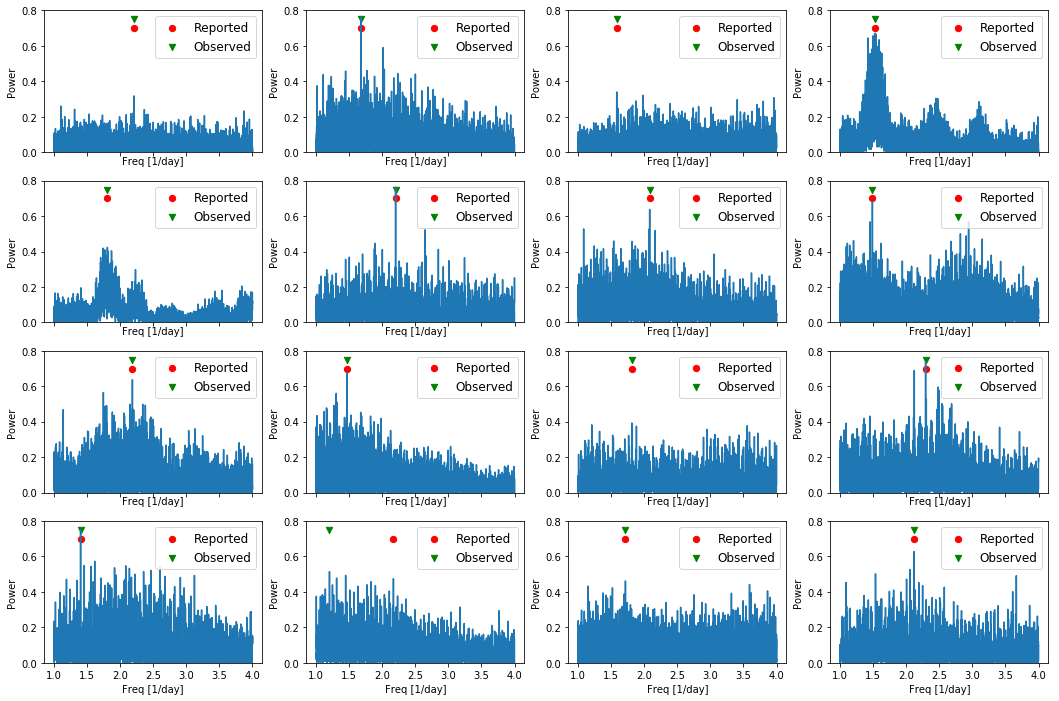

In [7]:
Gaia_freqs = np.zeros(N); LS_peaks = np.zeros(N); null_hyp_prob = np.zeros(N); Gaia_mags = np.zeros(N);

fig, ax = plt.subplots(4, 4, sharex = True, figsize=(18,12))

for i in range(N):
    t = photometry[i,0,:]
    t = t[~np.isnan(t)]
    mag = photometry[i,1,:]
    mag = mag[~np.isnan(mag)]
    LS = LombScargle(t, mag)
    LS_freq, LS_power = LS.autopower(minimum_frequency=1, maximum_frequency=4, samples_per_peak=20)
    null_hyp_prob[i] = LS.false_alarm_probability(LS_power.max())  
    Gaia_freqs[i] = 1/float((data[data['source_id'] == int(source_ids[i])])['pf'])
    Gaia_mags[i] = (data[data['source_id'] == int(source_ids[i])])['int_average_g']
    LS_peaks[i] = LS_freq[np.argmax(LS_power)]

    if i < 16:
        ax[i//4, i%4].set_ylim((0, 0.8))
        ax[i//4, i%4].plot(LS_freq, LS_power)
        ax[i//4, i%4].scatter(Gaia_freqs[i], 0.7, c='r', s=40, label="Reported")
        ax[i//4, i%4].scatter(LS_peaks[i], 0.75, c='g', s=40, marker="v", label="Observed")
        ax[i//4, i%4].legend(loc="upper right")
        
        ax[i//4, i%4].set_xlabel("Freq [1/day]")
        ax[i//4, i%4].set_ylabel("Power");

We see agreement with the catalog in all but one case. These were, however, the most observed stars. Below we have plotted (ordered after agreement with the catalog) the observed and reported frequencies, the distance between these values, and the "False Alarm Probability", provided by the Lomb-Scargle method. This value essentially tells us what the probability would be of getting a peak of the observed size, given that our data was simply gaussian noise. It is a fair estimate of how likely it is that our frequency actually "exists". We observe the most objects have a very low false positive probability, and a large majority of the observations would pass a p-test of 0.05 (requires them to be below the P=0.05 line).

We also observe that our estimates agree with reported values in 63% of cases.

Agreement percentage between calculated peeks and Gaia data = 63.0 %


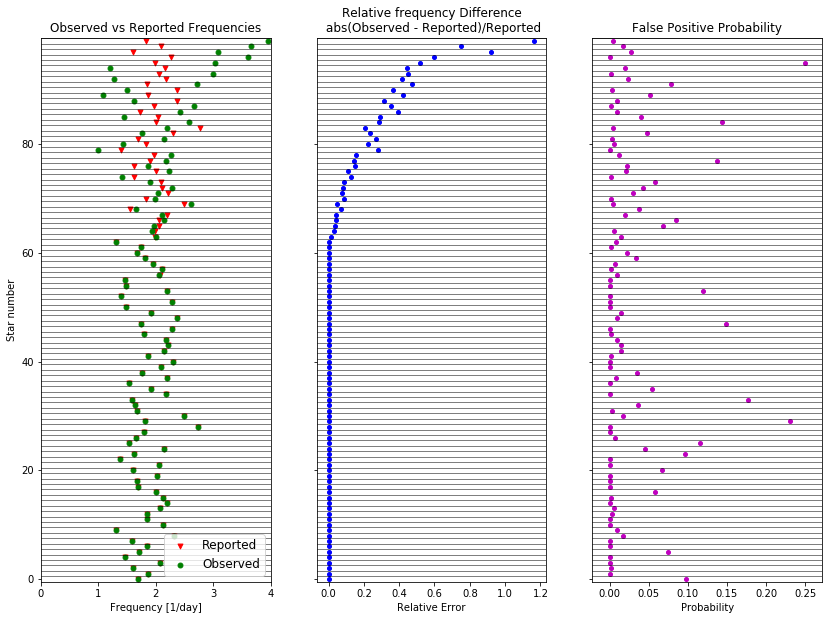

In [8]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize=(14,10))

peak_diff = np.abs(Gaia_freqs - LS_peaks)
sort_idx = np.argsort(peak_diff)
peak_diff_sorted = peak_diff[sort_idx]
Gaia_freqs_sorted = Gaia_freqs[sort_idx]
LS_peaks_sorted = LS_peaks[sort_idx]
null_hyp_prob_sorted = null_hyp_prob[sort_idx]

ax[0].scatter(Gaia_freqs_sorted, np.linspace(0, N-1, N), c='r', s=24, marker="v", label="Reported")
ax[0].scatter(LS_peaks_sorted, np.linspace(0, N-1, N), c='g', s=24, label="Observed")
ax[0].set_ylim((-0.5,99.5)); ax[0].set_xlim(0,4)
for i in range(N):
    ax[0].axhline(y=i+0.5, c='k', lw=0.5)
    ax[1].axhline(y=i+0.5, c='k', lw=0.5)
    ax[2].axhline(y=i+0.5, c='k', lw=0.5)
ax[1].scatter(peak_diff_sorted/Gaia_freqs_sorted, np.linspace(0, N-1, N), c='b', s=16)
ax[2].scatter(null_hyp_prob_sorted, np.linspace(0, N-1, N), c='m', s=16)
ax[0].set(xlabel='Frequency [1/day]'); ax[1].set(xlabel='Relative Error'); ax[2].set(xlabel='Probability'); ax[0].set_ylabel("Star number");
ax[0].set_title("Observed vs Reported Frequencies"); ax[1].set_title("Relative frequency Difference\n abs(Observed - Reported)/Reported"); ax[2].set_title("False Positive Probability");
ax[0].legend()

peaks_agree = np.abs(LS_peaks - Gaia_freqs) < 0.01
print(f"Agreement percentage between calculated peeks and Gaia data = {100*np.sum(peaks_agree)/N} %");

## 2.3 Magnitude comparisons
The magnitudes follow a more subtle trend, where most observations agree within a reasonable error of 10%, and none disagree a whole lot. This is very expected, as magnitudes aren't subject to the same possible error sources as a frequency analysis. We do however see that more objects have a "small but noticeable" error than in the frequencies, where ~60% fit extremely well.

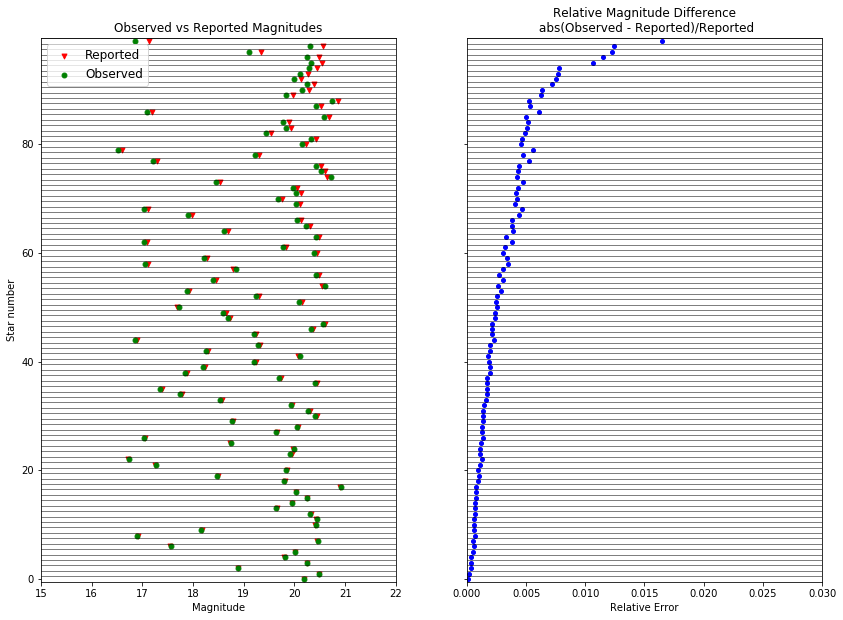

In [9]:
mag_diff = np.abs(Gaia_mags - mean_mag)
sort_idx = np.argsort(mag_diff)
mag_diff_sorted = mag_diff[sort_idx]
Gaia_mags_sorted = Gaia_mags[sort_idx]
mean_mag_sorted = mean_mag[sort_idx]
mag_diff_sorted = mag_diff[sort_idx]

fig, ax = plt.subplots(1, 2, sharey = True, figsize=(14,10))
ax[0].set_xlim(15,22); ax[0].set_ylim(-0.5,99.5)
ax[1].set_xlim(0, 0.03)
ax[0].scatter(mean_mag_sorted, np.linspace(0, N-1, N), c='r', s=24, marker="v", label="Reported")
ax[0].scatter(Gaia_mags_sorted, np.linspace(0, N-1, N), c='g', s=24, label="Observed")
ax[1].scatter(mag_diff_sorted/Gaia_mags_sorted, np.linspace(0, N-1, N), c='b', s=16)
for i in range(N):
    ax[0].axhline(y=i+0.5, c='k', lw=0.5)
    ax[1].axhline(y=i+0.5, c='k', lw=0.5)
ax[0].set(xlabel='Magnitude'); ax[1].set(xlabel='Relative Error'); ax[0].set_ylabel("Star number");
ax[0].set_title("Observed vs Reported Magnitudes"); ax[1].set_title("Relative Magnitude Difference\n abs(Observed - Reported)/Reported");
ax[0].legend();

# 3. Analysing and cleaning RR Lyrae data
We will from now on assume that the ```gaiadr2.vari_rrlyrae``` contains reliable period information.

In this section, we will pick out a set of RR Lyrae stars with low extinction and accurate measurements. These will form a baseline for our intrinsic color model. 

## 3.1 Query Setup
We submit an ADQL query to fetch the RR Lyrae periods from ```gaiadr2.vari_rrlyrae```, the usual suspects (parallax, magnitude, position etc) from ```gaiadr2.gaia_source```, as well as some distance estimates we will use later from  the ```external.gaiadr2_geometric_distance``` catalog. We also fetch quite a few things to be used later in the lab. The query is one of the slowest parts of the lab, and its preferable to only do it once.

We limit our search to objects that exist with a period in the RR Lyrae catalog, and require positive parallax, such that we can calculate absolute magnitudes, and finally that the objects have a listed bp_rp magnitude.

In [10]:
ADQL_query="""
SELECT  rr.source_id, rr.pf, rr.pf_error, rr.g_absorption,
        gs.phot_g_mean_mag+5*log10(gs.parallax)-10 AS mg,
        gs.ra, gs.dec, gs.parallax,
        gs.phot_bp_mean_flux, gs.phot_rp_mean_flux, gs.phot_rp_mean_flux_error, gs.phot_bp_mean_flux_error,
        gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.phot_g_mean_flux, gs.phot_g_mean_flux_error,
        gs.parallax_error, gs.parallax_over_error, gs.B, gs.L, gs.bp_rp, gs.astrometric_chi2_al,
        gs.phot_bp_rp_excess_factor, gs.astrometric_n_good_obs_al,
        gs.phot_bp_mean_flux_over_error, gs.phot_rp_mean_flux_over_error, gs.phot_g_mean_flux_over_error,
        geo_dis.r_est, geo_dis.r_lo, geo_dis.r_hi
FROM
    (SELECT * FROM gaiadr2.vari_rrlyrae WHERE NOT pf = 'NaN')
AS rr
JOIN
    (SELECT * FROM gaiadr2.gaia_source WHERE parallax > 0 AND NOT bp_rp = 'NaN' ) AS gs
ON
    rr.source_id = gs.source_id
JOIN
    external.gaiadr2_geometric_distance AS geo_dis
ON
    gs.source_id = geo_dis.source_id
"""

job = gaia.launch_job_async(ADQL_query)
data = job.get_results()
data = data.to_pandas()
print(f"Fetched {len(data)} objects and converted to pandas DataFrame.")

Query finished.
Fetched 60317 objects and converted to pandas DataFrame.


## 3.2 Finding low-extinction stars
Now, since our goal is to establish an intrinsic extinction baseline, its very important that we have accurate data, which has minimal dust in the way. We must be able to assume that the dust between us and the object is essentially zero, as we otherwise would get a false shift in our baseline. 

We will therefore impose some very strict conditions on our data before proceeding. We wish our data to
* be above the "galactic disk", such that not too much dust lies between us and the stars.
* have a parallax over parallax error ratio of more than 5 (corresponding to less than 20% error).
* be relatively nearby, with parallaxes above 0.25 mas (corresponding to distances less than 4kpc).

In order to keep the original data available, we apply these filter on our data in pandas, and keep the original data for later use.

In [11]:
data_subset = data[(np.abs(data['b']) > 30) & (data['parallax_over_error'] > 5) & (data['parallax'] > 1000.0/4000) ]
print(f"After cuts, {len(data_subset)} objects remain.")

After cuts, 462 objects remain.


We observe from the figure below that the objects in the galactic disk has indeed been removed. The above plot shows the objects in Right Ascension / Declination angles, while the below plot in Galactic Latitude / Longitude. We see that the cuts removed over 99% of the stars. It is however much more important that we are left with accurate data.

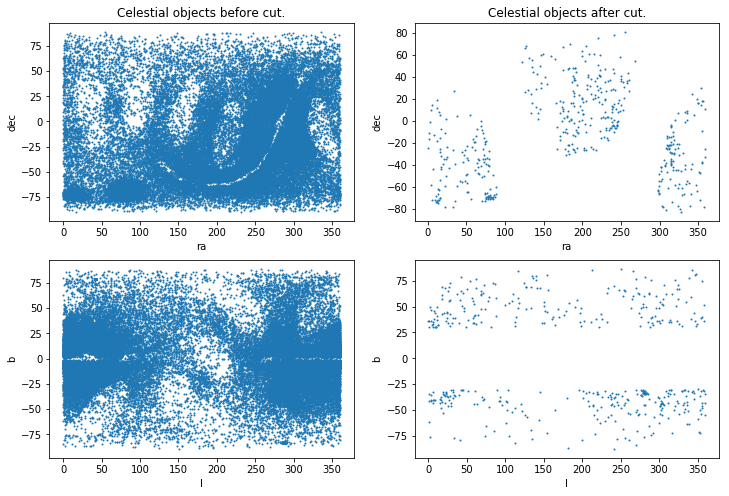

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax[0,0].scatter(data['ra'], data['dec'], s=1); ax[0,0].set_xlabel("ra"); ax[0,0].set_ylabel("dec");
ax[0,1].scatter(data_subset['ra'], data_subset['dec'], s=1); ax[0,1].set_xlabel("ra"); ax[0,1].set_ylabel("dec");
ax[0,0].set_title("Celestial objects before cut."); ax[0,1].set_title("Celestial objects after cut.");
ax[1,0].scatter(data['l'], data['b'], s=1); ax[1,0].set_xlabel("l"); ax[1,0].set_ylabel("b");
ax[1,1].scatter(data_subset['l'], data_subset['b'], s=1); ax[1,1].set_xlabel("l"); ax[1,1].set_ylabel("b");

## 3.3 Bailer-Jones distance estimates
There exists more advanced methods of distance-estimation than naively trusting parallaxes. We will employ one such method, described in [Bailer-Jones et al. 2018](https://arxiv.org/abs/1804.10121), which takes advantage of existing knowledge of galactic structure to place a prior on the parallax distance estimates. The distances are available in the ```external.gaiadr2_geometric_distance``` catalog, and we have already included them in the query above.

Below we see a comparison of the Bailer-Jonas distance estimates to the naive parallax estimates. The objects are simply sorted in increasing Parallax estimated distances. The two left plots show the estimated distances from each method, and the right plots show the difference between the two.

We observe that below ~500pc (the closest ~50 objects), the Bailor-Jones model estimates a slightly higher distance than the naive model. Above this distance however, it quickly pulls the other way, estimating a lower distance than the naive model. At the farthest distances, around 4000pc, it is underestimating by ~500pc.

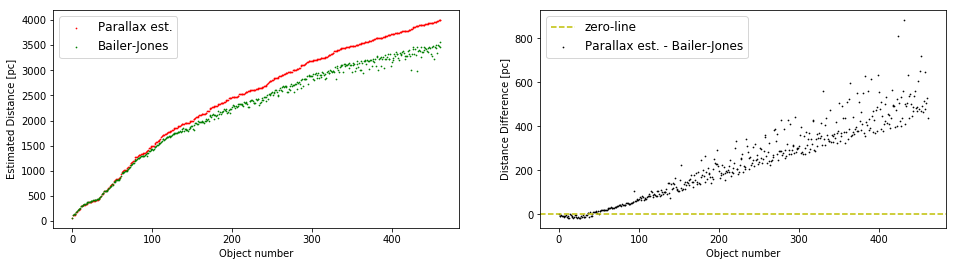

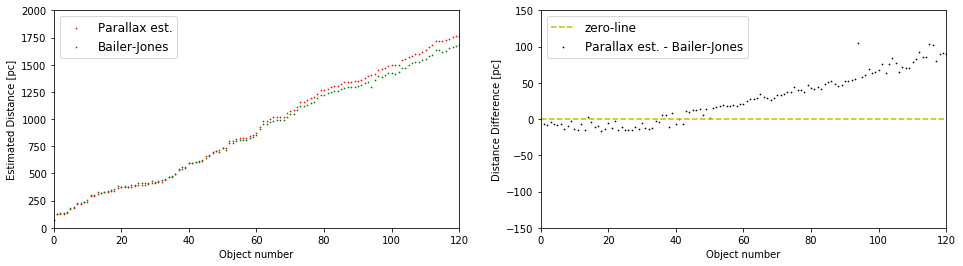

In [13]:
data_subset['d'] = 1000.0/data_subset['parallax']  # Parallax distance estimate in pc.
N = len(data_subset)
idx = np.array(np.argsort(data_subset['d']))

parallax_dist_sorted = np.array(data_subset['d'])[idx]
structure_dist_sorted = np.array(data_subset['r_est'])[idx]

fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].scatter(np.linspace(0, N-1, N), parallax_dist_sorted, c='r', s=0.5, label="Parallax est.")
ax[0].scatter(np.linspace(0, N-1, N), structure_dist_sorted, c='g', s=0.5, label="Bailer-Jones")
ax[1].scatter(np.linspace(0, N-1, N), (parallax_dist_sorted - structure_dist_sorted), c='k', s=0.5, label="Parallax est. - Bailer-Jones")
ax[1].axhline(y=0, ls='--', c='y', label="zero-line")
ax[0].set_xlabel("Object number"); ax[0].set_ylabel("Estimated Distance [pc]"); ax[0].legend()
ax[1].set_xlabel("Object number"); ax[1].set_ylabel("Distance Difference [pc]"); ax[1].legend()


fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].scatter(np.linspace(0, N-1, N), parallax_dist_sorted, c='r', s=0.5, label="Parallax est.")
ax[0].scatter(np.linspace(0, N-1, N), structure_dist_sorted, c='g', s=0.5, label="Bailer-Jones")
ax[1].scatter(np.linspace(0, N-1, N), (parallax_dist_sorted - structure_dist_sorted), c='k', s=0.5, label="Parallax est. - Bailer-Jones")
ax[0].set_xlim(0,120); ax[0].set_ylim(0,2000)
ax[1].set_xlim(0,120); ax[1].set_ylim(-150,150)
ax[1].axhline(y=0, ls='--', c='y', label="zero-line");
ax[0].set_xlabel("Object number"); ax[0].set_ylabel("Estimated Distance [pc]"); ax[0].legend()
ax[1].set_xlabel("Object number"); ax[1].set_ylabel("Distance Difference [pc]"); ax[1].legend();

## 3.4 Period-Magnitude Relations - First look
We will now begin to look at period-magnitude relations, and see if we can make some sensible cuts there as well.

We observe from the plot above that while most of the stars have very similar absolute magnitude, some are scattered away from the median. As RR Lyrae stars usually are very close in magnitude, we assume these to be bad data points. [Lindegren et al. 2018](https://arxiv.org/abs/1804.09366) described two conditions to filter this. The first, described in equation C1, puts a condition on the unit weight error $u=(\chi^2/\nu)^{1/2}$, where $\chi^2$ is the usual chi-squared error statistic, $\chi^2 = \sum ...$, and $\nu$ is the degrees of freedom in the model. $\chi^2$ is given as ```astrometric_chi2_al``` in the catalog, and $\nu$ can be derived as the number of observations minus the number of free variables in the model:```astrometric_n_good_obs_al - 5```. The condition is
\\[
    u < 1.2\ \text{max}(1,\ e^{−0.2(G − 19.5)})
\\]

The second condition described, in C2, is on the flux excess factor, $E = (I_{BP} - I_{RP})/I_G$, available in the catalog as ```phot_bp_rp_excess_factor``` and is aimed at reducing photometric errors. The condition is

\\[
    1.0 + 0.015(G_{BP} − G_{RP})^2 < E < 1.3 + 0.06(G_{BP} − G_{RP})^2
\\]

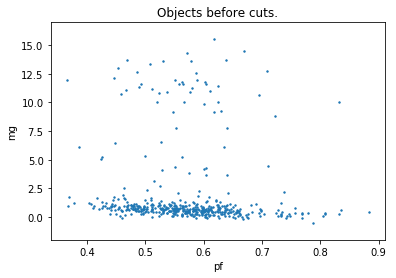

In [14]:
data_subset.plot.scatter('pf','mg', s=2); plt.title("Objects before cuts."); plt.ylim(-2, 17);

Below, we have employed both conditions described above. We observe that they remove ~40, or 10%, of the stars. Many of the removed stars were scattered far above the median, which is a good sign.

In [15]:
data_subset['u'] = np.sqrt(data_subset['astrometric_chi2_al']/(data_subset['astrometric_n_good_obs_al'] - 5))

The first cut reduces data size from 462 to 426.
The second cut further reduces data size to 409.


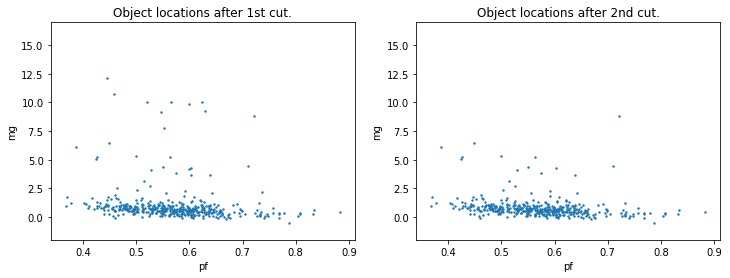

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

data_subset2 = data_subset.copy()
data_subset2 = data_subset2[ data_subset2['u'] < 1.2*np.max( (np.ones(len(data_subset2)), np.exp(-0.2*(data_subset2['phot_g_mean_mag'] - 19.5))), axis=0) ]
print(f"The first cut reduces data size from {len(data_subset)} to {len(data_subset2)}.")
ax[0].scatter(data_subset2['pf'], data_subset2['mg'], s=2); ax[0].set_xlabel("pf"); ax[0].set_ylabel("mg")
ax[0].set_title("Object locations after 1st cut."); ax[0].set_ylim(-2, 17);

data_subset2 = data_subset2[(1.0 + 0.015*data_subset2['bp_rp']**2 < data_subset2['phot_bp_rp_excess_factor']) &\
                            (data_subset2['phot_bp_rp_excess_factor'] < 1.3 + 0.06*data_subset2['bp_rp']**2)]
print(f"The second cut further reduces data size to {len(data_subset2)}.")
ax[1].scatter(data_subset2['pf'], data_subset2['mg'], s=2); ax[1].set_xlabel("pf"); ax[1].set_ylabel("mg")
ax[1].set_title("Object locations after 2nd cut."); ax[1].set_ylim(-2, 17);

The two cuts were obviously rather successful at removing the unwanted data points. Some do still remain, however. Doing a rough eye-estimation, we observe that the rest of the outliers can be removed by cutting all magnitudes above 2. This is done below, further reducing the dataset. The visualization of this cut is left as an exercise to the reader.

In [17]:
data_subset2 = data_subset2[(data_subset2['mg'] < 2)]
print(f"The third cut finally reduces data size to {len(data_subset2)}.")

The third cut finally reduces data size to 390.


# 4. Deriving a period-magnitude relation using MCMC
We will now use our newly acquired accurate star data to derive the avaited period-magnitude relation.

## 4.1 Magnitude Errors
First we will take a quick detour to look at magnitude uncertainties, as having these available will increase the accuracy of our MCMC obtained model.

The absolute magnitude ($M$) can be calculated from estimated apparent magnitude ($m$) and parallax ($p$) as

\\[
    M = m + 5 \log_{10}(p) - 10, \quad\quad m = -2.5\log_{10}\left( \frac{F}{F_0} \right)
\\]

Using standard error propagation, this would give an error to the magnitude as

\\[
    \sigma_M = \sqrt{\left(\frac{\partial M}{\partial m}\right)^2\sigma_m^2 + \left(\frac{\partial M}{\partial p}\right)^2\sigma_p^2}
\\]

Turns out, the error to the parallax is far larger than the error in flux (and thereby apparent magnitude), and a good approximation can be found using only the parallax error:

\\[
    \sigma_M \approx \left|\frac{\partial M}{\partial p} \sigma_p \right| = \left|\frac{5}{\ln(10)}\frac{\sigma_p}{p} \right|
\\]


Employing this to the data we get below observe that the magnitude errors are rather substantial, because Parallax errors are usually rather large compared to many other observables.

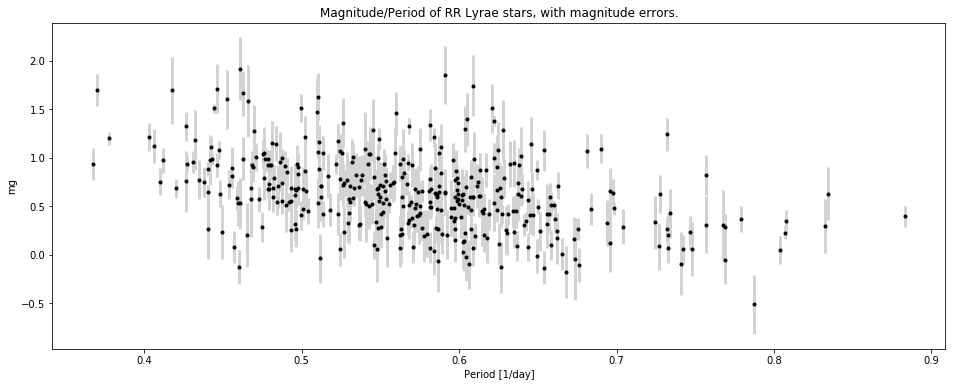

In [18]:
data_subset2['mg_error'] = np.abs(5/np.log(10) * data_subset2['parallax_error']/data_subset2['parallax'])
plt.figure(figsize=(16,6))
plt.errorbar(data_subset2['pf'], data_subset2['mg'], yerr=data_subset2['mg_error'],  fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label="Objects")
plt.xlabel("Period [1/day]"); plt.ylabel("mg"); plt.title("Magnitude/Period of RR Lyrae stars, with magnitude errors.");

## 4.2 Intrinsic Scatter
We have included an intrinsic scatter parameter in our MCMC model, labeled as $\lambda$. This parameter represent any dependencies and errors we have not included in our simulation. Imagine that we had access to unlimited RR Lyrae data, with our current parameters. We would probably find that there is some error, or width, to our model fit that could not be accounted for by our paramters or their errors. Metallicity is one such example that we have no included in our model.

This is solved by introducing a scatter parameter $\lambda$, represents the residual error about our logarithmic fit, that cannot be accounted for by errors in the paramters we have included. It's relative magnitude to the other errors will tell us something about how much of our errors comes from sources "out of our current control". In other words, if $\lambda$ is much larger than other errors, we already have as good a model as we're gonna get with our current parameters, and we need a better model, not more data. This is further explored in i.e. [Klein & Bloom 2014](https://arxiv.org/abs/1404.4870), and the mcm implementation can be found [here](https://dfm.io/posts/fitting-a-plane/).

Note that since we've implemented $\lambda$ in log-space, the actual intrinsic standard error is
\\[
    \sigma_{intrinsic} = \log(\lambda)
\\]

## 4.3 Likelihood
We assume all the data to have gaussian error distributions around the true, unknown, model. This means that the likelihood of finding the datapoint $D_i$ given that the true model-point is $y_i$, is
\\[
    P(D_i \mid m,b,\lambda) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} e^{-\frac{(D_i - y_i)^2}{2\sigma_i^2}}
\\]

As is common in likelihood-statistics, we take the logarithm of this likelihood, as it is often nicer to deal with. Relative probabilities are unaffected by a logarithm, and products neatly turns into sums. After dropping some constants, which also doesn't contribute to relative probability, we get

\\[
\ln p\left(f_{n \lambda} | \boldsymbol{\theta}_{\lambda}^{T}, \ell_{n}\right)=-\frac{1}{2} \frac{\left[f_{n \lambda}-\boldsymbol{\theta}_{\lambda}^{T} \cdot \ell_{n}\right]^{2}}{\sigma_{n \lambda}^{2}}-\frac{1}{2} \ln \left(\sigma_{n \lambda}^{2}\right)
\\]

## 4.4 Prior
Now, we have little prior knowledge we can employ in our prior, and will therefore go with an uninformed top-hat prior. We know roughly in what interval we should expect our values to lie, and employ the prior

\\[
\log{P(a,b,\lambda)} = \left\{\begin{array}{lr}
        0, & \text{for } -5\leq a\leq 1 \ \text{and} -5\leq b\leq 5 \ \text{and} -5 \leq \lambda \leq 5 \\
        -\infty, & \text{otherwise }
        \end{array}\right\}
\\]

The combined, logarithmic probability, simply becomes the likelyhood within the boundaries set by the prior, and 0 (or -inf in log-space) elsewhere.

In [19]:
def lnlike(theta, x, y, yerr):
    a, b, lamb = theta
    model = a*np.log10(x) + b
    inv_sigma2 = 1.0/(yerr**2 + np.exp(2*lamb))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    a, b, lamb = theta
    if -5.0 <= a <= 1.0 and -3 <= b <= 3 and -5 < lamb < 5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

## 4.5 Running the simulation
We start the simulation with 16 walkers with 1000 iterations. The initial conditions are rather randomly chosen, as $a_0 = 1 + \sigma$, and $b_0 = 1 + \sigma$, for some randomly generated small $\sigma$'s.

In [20]:
seed = 92687576
np.random.seed(seed)
ndim, nwalkers = 3, 16
initial_a, initial_b, initial_lamb = 1, 1, 1
pos = [(initial_a, initial_b, initial_lamb) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
print(f"emcee version = {emcee.__version__}")
x = data_subset2['pf']
y_data = data_subset2['mg']
y_err = data_subset2['mg_error']
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))

emcee version = 2.2.1


In [21]:
niterations = 1000
sampler.reset()
sampler.run_mcmc(pos, niterations);

## 4.6 Analyzing convergence
Now that the sampling is finished, we need to know that the walkers converged, and the results are reliable.

Below we have plotted a and b values for all walkers over each step. It is very evident that they reach a steady solution after around ~200 steps. The same can be seen from the plotted logarithmic probability function, where it reaches a steady-state for all walkers.

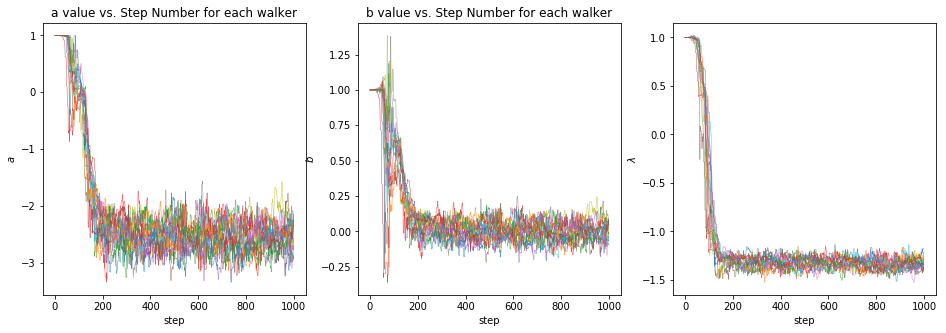

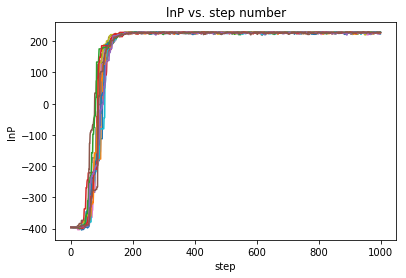

In [22]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
y_labels = ['$a$', '$b$', '$\lambda$']
x_labels = 'step'
ax[0].set_title('a value vs. Step Number for each walker')
ax[1].set_title('b value vs. Step Number for each walker')
for i,j in enumerate(sampler.chain[0,0,:]):
    ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_xlabel(x_labels)
plt.figure(figsize=(6.1,4))
plt.plot(sampler.lnprobability.T);
plt.ylabel('lnP'); plt.xlabel('step'); plt.title('lnP vs. step number');

The beginning of the walker-chain is very sensitive to initial conditions, and should not be included in the results. Cutting out the first 300 results, called a burn-in, will ensure that our data comes from a steady-state solution. This is implemented below.

In [23]:
burn_in = 300
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

The corner plot below shows the posterior probability distribution for a, b, and $\lambda$. We see a rather strong covariance between a and b. It should be noted that this covariance could have been removed by doing a *linear* fit on magnitude vs *log(P)*, instead of a logarithmic fit of magnitude vs P, because we then would be able to re-scale the period to its mean.

There is no covariance between $\lambda$ and a or b.

corner version=2.0.1


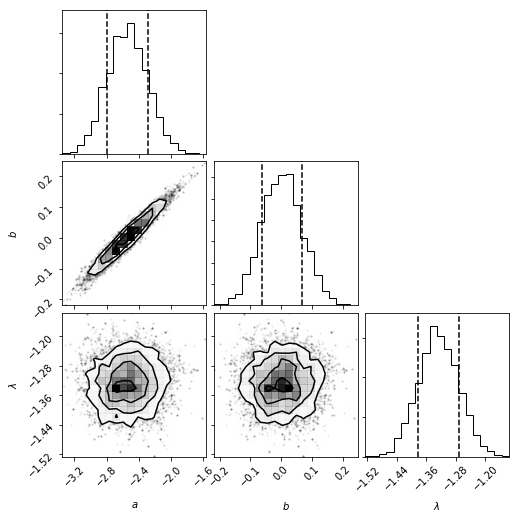

In [24]:
import corner
print(f"corner version={corner.__version__}")
fig = corner.corner(samples, labels=["$a$", "$b$", "$\lambda$"], quantiles=[0.16, 0.84]);

## 4.6 Results
Now that we have convinced ourselves that the results are valid, we can take an actual look at them. Below we have plotted all the data with error bars, together with the plot of 50 randomly chosen a and b samples from the posterior  data. The random plots gives a fair view of the error of the best fit. We can observe that the spread is reasonably small, and there is for instance no doubt about the positive trend in the magnitude/period relation. The low variance is somewhat surprising, given the large variance and error in the data. Maybe it is related to the logarithmic fit, and the data would appear cleaner if we did a linear fit with $\log(P)$ as the parameter.

We can also observe that $\lambda$ is around -1.3, giving an intrinsic error of around 0.05, which is a handfull factors smaller than the error in the slope. This indicates that we could benefit from more data, and we would not get a particularly large gain by changing our model to something more sophisticated.

mcmc results for a: -2.5417 (+0.2522/-0.2568)

mcmc results for b: 0.0027 (+0.0659/-0.0656)

mcmc results for lambda: -1.3279 (+0.0554/-0.0541)



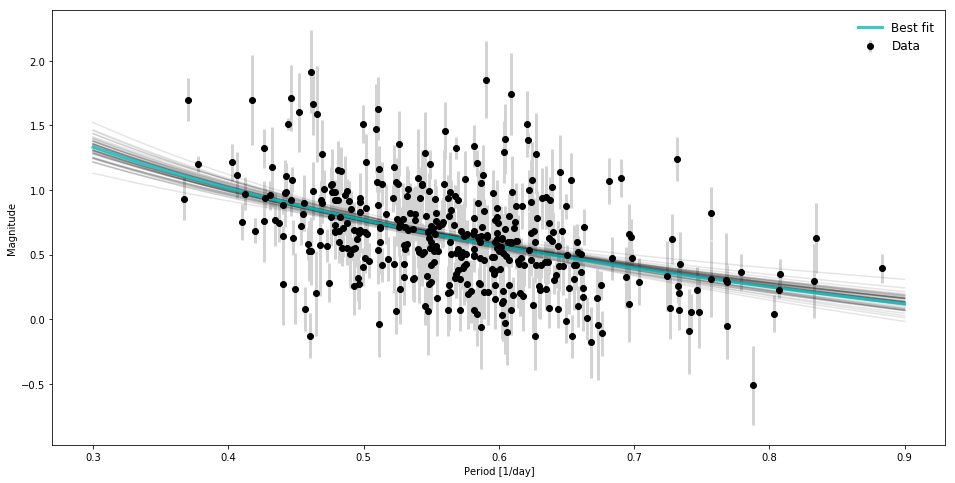

In [25]:
plt.figure(figsize=(16,8))
period_span = np.linspace(0.3, 0.9, 1001)

for a, b, lamb in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(period_span, a*np.log10(period_span)+b, color="k", alpha=0.1)

a_V, b_V, lamb_V = np.percentile(samples, 50, axis=0)
plt.plot(period_span, a_V*np.log10(period_span)+b_V, color="c", lw=3, alpha=0.8, label='Best fit')
    plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label='Data')

plt.xlabel("Period [1/day]")
plt.ylabel("Magnitude")
plt.legend(frameon=False);

a_mcmc, b_mcmc, lamb_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(f"mcmc results for a: {a_mcmc[0]:.4f} (+{a_mcmc[1]:.4f}/-{a_mcmc[2]:.4f})\n")

print(f"mcmc results for b: {b_mcmc[0]:.4f} (+{b_mcmc[1]:.4f}/-{b_mcmc[2]:.4f})\n")

print(f"mcmc results for lambda: {lamb_mcmc[0]:.4f} (+{lamb_mcmc[1]:.4f}/-{lamb_mcmc[2]:.4f})\n")

# 5. Producing and comparing with period/magnitude relations from WISE data
The WISE survey also identified magnitudes of RR Lyrae stars, in the near infrared. We will now se how this magnitude data affects the best-fit trend.

We begin by querying for all the WISE data, storing them in a separate pandas object.

In [26]:
x = "("
for i in data_subset2['source_id']:
    x += f"{i}, "
x = x[:-2]
x += ")"

ADQL_query_WISE = """
    SELECT GDR2.source_id, WISE.w2mpro+5*log10(GDR2.parallax)-10 AS mg,
        GDR2.parallax, GDR2.parallax_error, rr.pf, WISE.w2mpro, WISE.w2mpro_error
        FROM (
            SELECT * FROM gaiadr2.allwise_best_neighbour WHERE source_id IN
            """ + x + """
        ) AS best_neighbour
    JOIN (SELECT * FROM gaiadr2.gaia_source WHERE parallax > 0) AS GDR2
        ON GDR2.source_id = best_neighbour.source_id
    JOIN gaiadr1.allwise_original_valid AS WISE
        ON best_neighbour.allwise_oid = WISE.allwise_oid
    JOIN
        (SELECT * FROM gaiadr2.vari_rrlyrae WHERE NOT pf = 'NaN') AS rr
    ON rr.source_id = GDR2.source_id
"""
job = gaia.launch_job_async(ADQL_query_WISE)
data_wise = job.get_results()
data_wise = data_wise.to_pandas()

Query finished.


## 5.1 Visual comparison
Now, plotting the magnitude data from each catalog clearly shows that the magnitudes differ by quite a lot. As they are of different frequency bands, this is of little significance. The trend is of more importance, but is harder to establish, although the WISE data seems to have even more of a negative trend that is visible in the Gaia DR2 data.

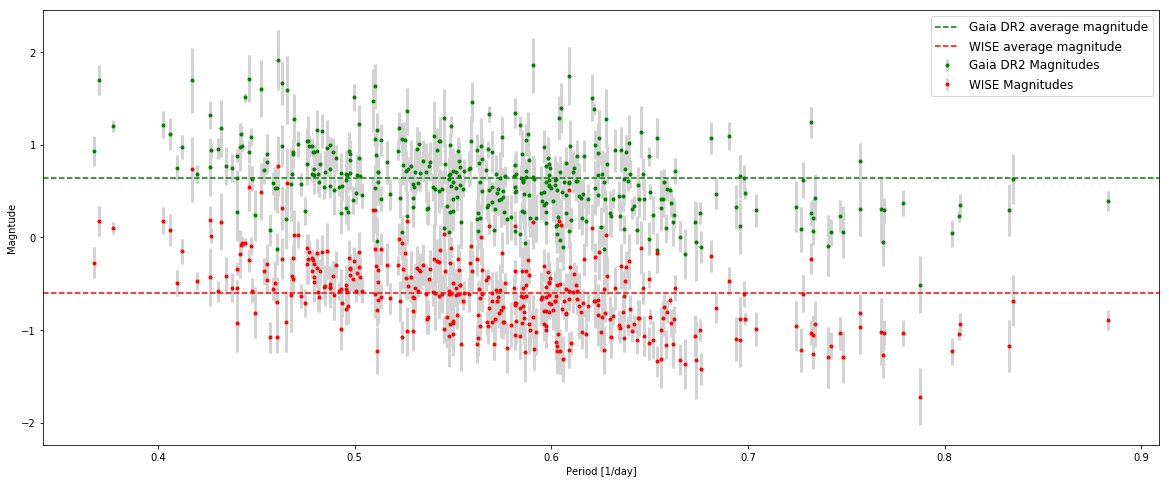

In [27]:
data_wise['mg_error'] = np.abs(5/np.log(10) * data_wise['parallax_error']/data_wise['parallax'])
plt.figure(figsize=(20,8))
plt.errorbar(data_subset2['pf'], data_subset2['mg'], yerr=data_subset2['mg_error'],  fmt='.', color='green', ecolor='lightgray', elinewidth=3, capsize=0, label="Gaia DR2 Magnitudes")
plt.errorbar(data_wise['pf'], data_wise['mg'], yerr=data_wise['mg_error'],  fmt='.', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label="WISE Magnitudes")
plt.axhline(y = np.mean(data_subset2['mg']), ls="--", c='g', label="Gaia DR2 average magnitude")
plt.axhline(y = np.mean(data_wise['mg']), ls="--", c="r", label="WISE average magnitude")
plt.xlabel("Period [1/day]"); plt.ylabel("Magntude"); plt.legend();

## 5.2 Running the simulation
We repeat the exact same simulation as before. See last section for details. The magnitude error are calculated above using the same technique as in last section, using WISE parallax and error data.

In [28]:
seed = 92687576
np.random.seed(seed)
ndim, nwalkers = 3, 16
initial_a, initial_b, initial_lambda = 1, 1, 1
pos = [(initial_a, initial_b, initial_lambda) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
x = data_wise['pf']
y_data = data_wise['mg']
y_err = data_wise['mg_error']

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))
sampler.reset()
sampler.run_mcmc(pos, niterations);

## 5.3 Convergence
Convergence-wise, our observations are rather identical to the previous section, as can be seen from the plots below. Although the parameters converge on different values, they look to shake off their initial conditions in the same time-span as before. We repeat the same burn-in also for this dataset.

The corner covariance plots also look very similar.

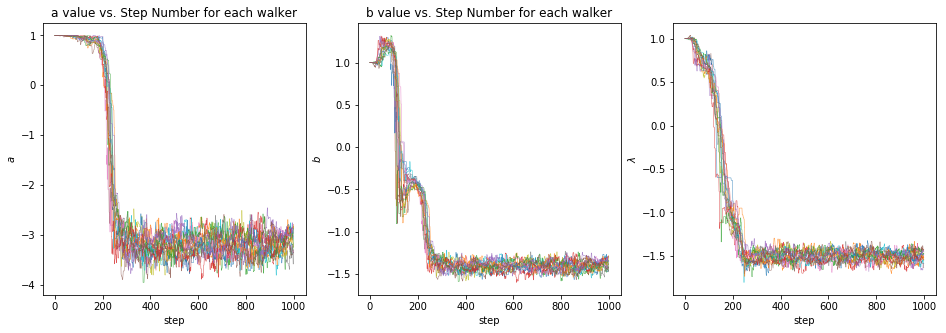

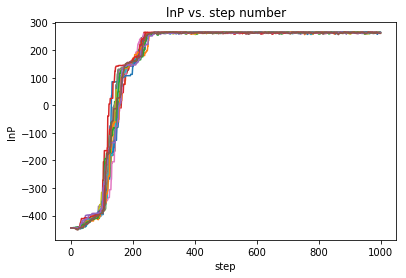

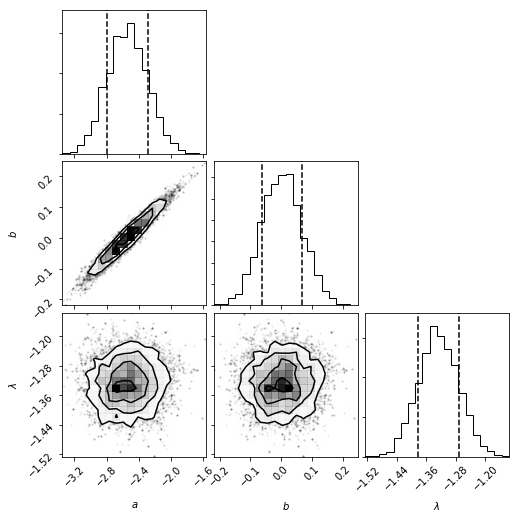

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
y_labels = ['$a$', '$b$', '$\lambda$']
x_labels = 'step'
ax[0].set_title('a value vs. Step Number for each walker')
ax[1].set_title('b value vs. Step Number for each walker')
for i,j in enumerate(sampler.chain[0,0,:]):
    ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_xlabel(x_labels)
plt.figure(figsize=(6.1, 4))
plt.plot(sampler.lnprobability.T);
plt.ylabel('lnP'); plt.xlabel('step'); plt.title('lnP vs. step number');
fig = corner.corner(samples, labels=["$a$", "$b$", "$\lambda$"], quantiles=[0.16, 0.84]);

In [30]:
burn_in = 300
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

## 5.4 Results
The data is plotted below, together with the best-fit model and 50 random lines from posterior data.

mcmc results for a: -3.1983 (+0.2228/-0.2059)

mcmc results for b: -1.4029 (+0.0556/-0.0542)

mcmc results for lambda: -1.4967 (+0.0563/-0.0643)



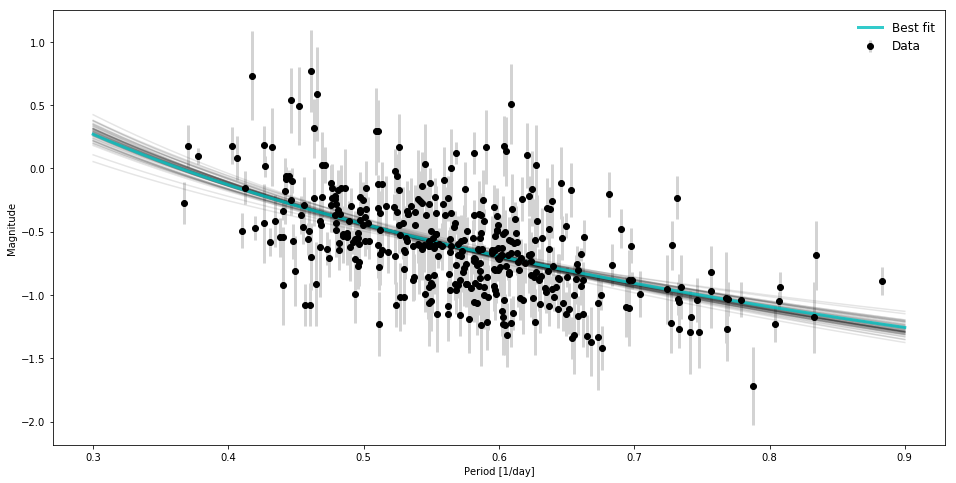

In [31]:
plt.figure(figsize=(16,8))
period_span = np.linspace(0.3, 0.9, 1001)

for a, b, lamb_mcmc in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(period_span, a*np.log10(period_span)+b, color="k", alpha=0.1)

a_W2, b_W2, lamb_mcmc = np.percentile(samples, 50, axis=0)
plt.plot(period_span, a_W2*np.log10(period_span)+b_W2, color="c", lw=3, alpha=0.8, label='Best fit')
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label='Data')

plt.xlabel("Period [1/day]")
plt.ylabel("Magnitude")
plt.legend(frameon=False);

a_mcmc, b_mcmc, lamb_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(f"mcmc results for a: {a_mcmc[0]:.4f} (+{a_mcmc[1]:.4f}/-{a_mcmc[2]:.4f})\n")

print(f"mcmc results for b: {b_mcmc[0]:.4f} (+{b_mcmc[1]:.4f}/-{b_mcmc[2]:.4f})\n")

print(f"mcmc results for lambda: {lamb_mcmc[0]:.4f} (+{lamb_mcmc[1]:.4f}/-{lamb_mcmc[2]:.4f})\n")

## 5.5 Comparison
The results from both the WISE near-infrared data and the Gaia DR2 visible data look overall very similar. The general shape and error in the data look very alike, but the parameters are somewhat different. The WISE data has a larger offset (b-value), which isn't very interesting, since it's just a magnitude offset, which differ between bands. More interestingly, the near-infrared stars have a steeper negative slope on its logarithmic fit, with -3.23 vs -2.58 (may vary from run to run).

This difference is confirmed by the literature. [Klein & Bloom 2014](https://arxiv.org/abs/1404.4870) shows a slope of −2.2337 ± 0.1249 in the W2 infrared band, and −0.4091 ± 0.2370 in the visible V-band. While this disagrees a fair amount by our observations, it is in the same ballpark, and roughly agrees on the ratio between the two bands. Below we have plotted our fit vs the Klein & Bloom fit for the W2 band. We see that they could both reasonably agree with the data, and the difference may very well be due to difference in chosen stars.

[Beaton et al. 2018](https://arxiv.org/abs/1808.09191) divides the RR Lyrae stars further into categories, and only looks at J, H, and K bands, all lying between the V and W2 bands. They do however place all stars in the slope range of $[-2.5, -1.7]$, with the more negative slope for the higher wavelength, in agreement with us and Klein & Bloom 2014. Both papers also agrees on slopes less steep than ours, in both visible and near-infrared.

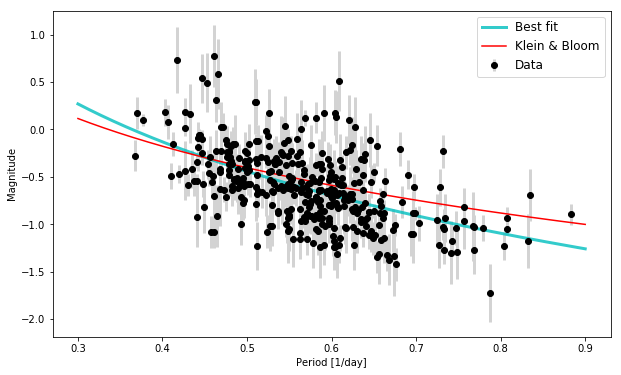

In [32]:
a, b, lamb = np.percentile(samples, 50, axis=0)
plt.figure(figsize=(10,6))
plt.plot(period_span, a_W2*np.log10(period_span)+b_W2, color="c", lw=3, alpha=0.8, label='Best fit')
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label='Data')
plt.plot(period_span, -2.337*np.log10(period_span/0.529) - 0.46, c='r', label='Klein & Bloom'); plt.legend(); plt.xlabel('Period [1/day]'), plt.ylabel('Magnitude');

# 6. Deriving a period/color relation.
## 6.1 Error estimation

The $bp\_rp = G_{bp} - G_{rp}$ is a function of each respective fluxes. Removing some factors that will disapear during a derivative anyway, we have

\\[
    G_{bp} - G_{rp} = 2.5\log(F_{bp}) + 2.5\log(F_{rp})
\\]

such that

\\[
    \left(\frac{\partial}{\partial F_{bp}} [G_{bp} - G_{rp}] \right)^2 = \frac{2.5^2}{\ln(10)^2}\frac{1}{F_{bp}^2}  \quad\quad\text{and}\quad\quad \left(\frac{\partial}{\partial F_{rp}} [G_{bp} - G_{rp}] \right)^2 = \frac{2.5^2}{\ln(10)^2}\frac{1}{F_{rp}^2}
\\]

such that

\\[
    \sigma_{bp\_rp} = \sqrt{\left(\frac{\partial rp\_bp}{\partial F_{rp}}\right)^2\sigma_{rp}^2 + \left(\frac{\partial bp\_rp}{\partial F_{bp}}\right)^2\sigma_{bp}^2}
    = \frac{2.5}{\ln(10)} \sqrt{\frac{1}{F_{rp}^2}\sigma_{rp}^2 + \frac{1}{F_{bp}^2}\sigma_{bp}^2}
\\]

This error is implemented in the code below, together with a scatter plot of the data. We notice a slight positive trend. All in all, the data doesn't drastically differ in distribution, error or shape from previous data, and the MCMC simulations should probably go smoothly.

In [33]:
data_subset2['sigma_bp_rp'] = 2.5/np.log(10)*np.sqrt(\
data_subset2['phot_bp_mean_flux_error']**2/data_subset2['phot_bp_mean_flux']**2 + \
data_subset2['phot_rp_mean_flux_error']**2/data_subset2['phot_rp_mean_flux']**2 )

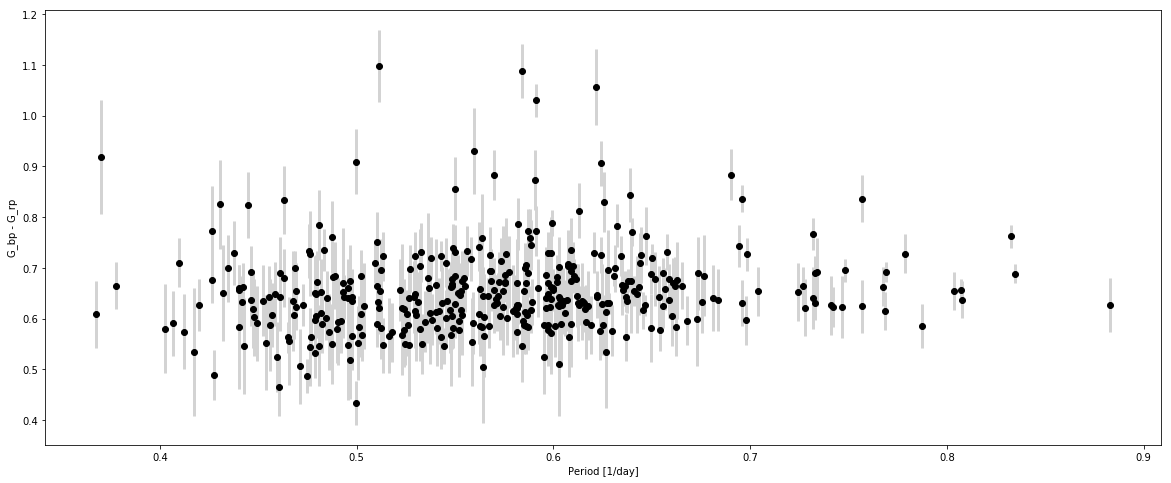

In [34]:
plt.figure(figsize=(20,8))
plt.errorbar(data_subset2['pf'],data_subset2['bp_rp'], yerr=data_subset2['sigma_bp_rp'], ls='none', marker='o', fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label='Data');
plt.xlabel("Period [1/day]"); plt.ylabel("G_bp - G_rp");

## 6.2 Running the simulation
The same method is used for running the MCMC simulation.

In [35]:
seed = 92687576

np.random.seed(seed)
ndim, nwalkers = 3, 16
initial_a, initial_b, initial_lamb = 1, 1, 1
pos = [(initial_a, initial_b, initial_lamb) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
x = data_subset2['pf']
y_data = data_subset2['bp_rp']
y_err = data_subset2['sigma_bp_rp']

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))
sampler.reset()
sampler.run_mcmc(pos, niterations);

## 6.3 Convergence
Like before, we observe a convergence of parameters well before 200 steps. By good measure, we let the burn-in run to 300 steps.

The same point made in section 4 about the corner plot and removal of covariance applies here as well.

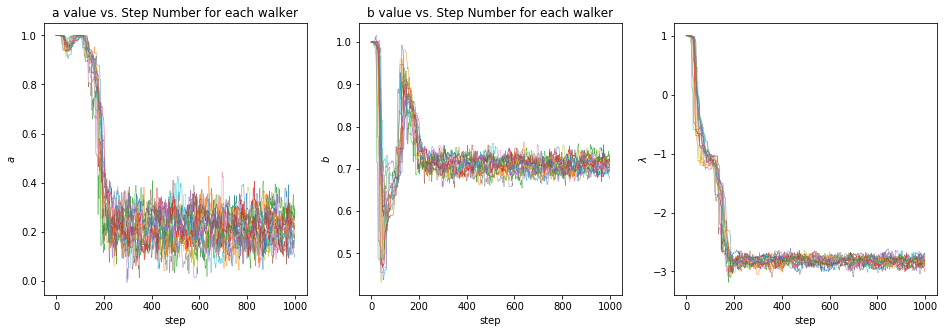

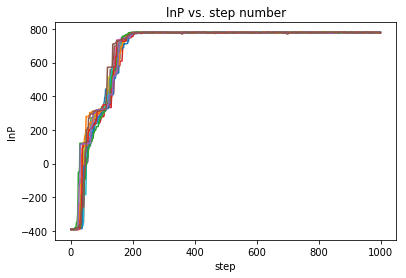

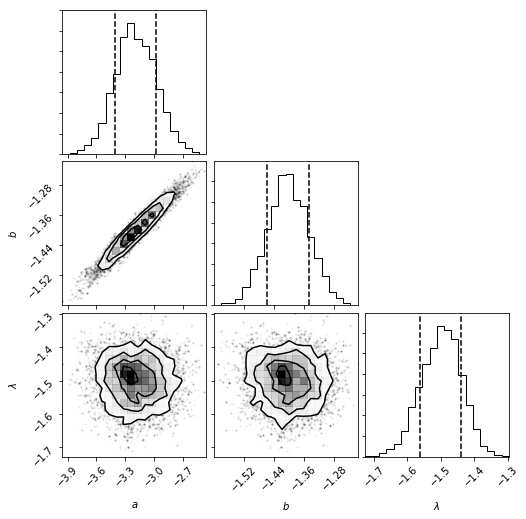

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
y_labels = ['$a$', '$b$', '$\lambda$']
x_labels = 'step'
ax[0].set_title('a value vs. Step Number for each walker')
ax[1].set_title('b value vs. Step Number for each walker')
for i,j in enumerate(sampler.chain[0,0,:]):
    ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_xlabel(x_labels)
plt.figure(figsize=(6.1, 4))
plt.plot(sampler.lnprobability.T);
plt.ylabel('lnP'); plt.xlabel('step'); plt.title('lnP vs. step number');
fig = corner.corner(samples, labels=["$a$", "$b$", "$\lambda$"], quantiles=[0.16, 0.84]);

In [37]:
burn_in = 300
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

## 6.4 Results
The results show a slight positive trend, as expected. The error estimations also look comfortably small.

Summarizing, we have looked at stars with accurate measurements, with high galactic latitude. We should be able to assume that these stars have near-zero extinction, and they will therefore serve as our intrinsic color baseline.

The logarithmic best-fit model we just found will serve as this baseline. It was found to be approximately (might differ slightly for each run):

\\[
    (G_{BP} - G_{RP})_{\text{intrinsic}} = 0.25\cdot log_{10}(P) + 0.72
\\]

The same notes of instrinsic scattering made in section 4 applies here as well. $\sigma_{intrinsic}$ is relatively small.

mcmc results for a: 0.2160 (+0.0627/-0.0659)

mcmc results for b: 0.7109 (+0.0146/-0.0173)

mcmc results for lambda: -1.4967 (+0.0563/-0.0643)

Fit function: 0.2160*log10(P)+0.7109


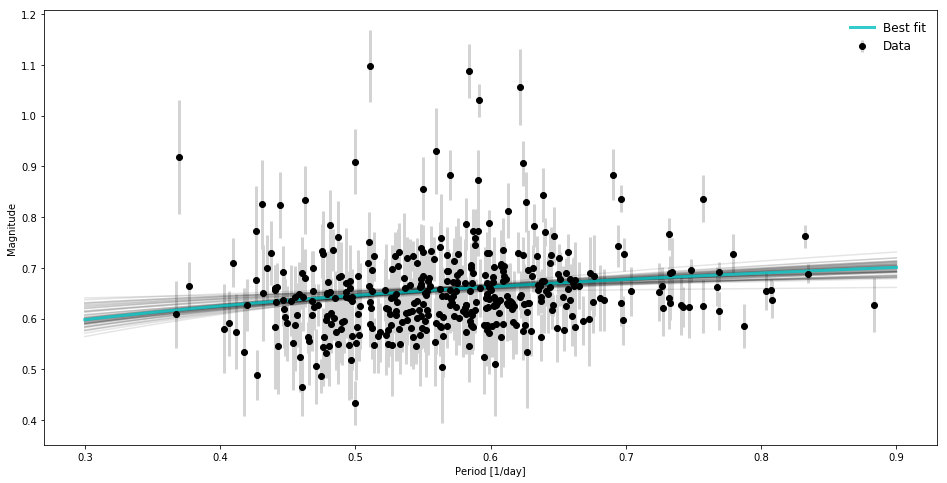

In [38]:
plt.figure(figsize=(16,8))
period_span = np.linspace(0.3, 0.9, 1001)

for a, b, lamb in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(period_span, a*np.log10(period_span)+b, color="k", alpha=0.1)

a, b, lamb = np.percentile(samples, 50, axis=0)
plt.plot(period_span, a*np.log10(period_span)+b, color="c", lw=3, alpha=0.8, label='Best fit')
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label='Data')

plt.xlabel("Period [1/day]")
plt.ylabel("Magnitude")
plt.legend(frameon=False);

a_mcmc, b_mcmc, lamb = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(f"mcmc results for a: {a_mcmc[0]:.4f} (+{a_mcmc[1]:.4f}/-{a_mcmc[2]:.4f})\n")

print(f"mcmc results for b: {b_mcmc[0]:.4f} (+{b_mcmc[1]:.4f}/-{b_mcmc[2]:.4f})\n")

print(f"mcmc results for lambda: {lamb_mcmc[0]:.4f} (+{lamb_mcmc[1]:.4f}/-{lamb_mcmc[2]:.4f})\n")

print(f"Fit function: {a:.4f}*log10(P)+{b:.4f}")

In [39]:
def intrinsic(period):
    return a*np.log10(period) + b

# 7. Back to all the stars

## 7.1 Calculating extinction
Now that we have established our intrinsic color baseline, we will go back to looking at all the color data of all the stars. This data is already available from our original, unfiltered query of the Gaia database.

Since we are now able to estimate the intrinsic color for any RR Lyrae star with a known period, we can calculate its color excess as

\\[
    E(G_{BP} - G_{RP}) = E(G_{BP} - G_{RP})_{\text{observed}} - E(G_{BP} - G_{RP})_{\text{intrinsic}}
\\]

This is done in the code below, together with the related value of G-band extinction:

\\[
        A_G = R_G\cdot E(G_{BP} - G_{RP}) = 2\cdot E(G_{BP} - G_{RP})
\\]

In [40]:
data['color_excess'] = data['bp_rp'] - intrinsic(data['pf'])
data['Ag'] = 2*data['color_excess']

## 7.2 Comparing to Gaia and filtering
Gaia reports g-band extinction for all stars. Cross-referencing this with our own calculations, we observe from the plot below that the color/period trend is very similar, although there is some minor differences. Gaia also reports no extinction below 0, which makes a lot of sense.

The average deviation in Ag between observations and Gaia, is 0.2959.


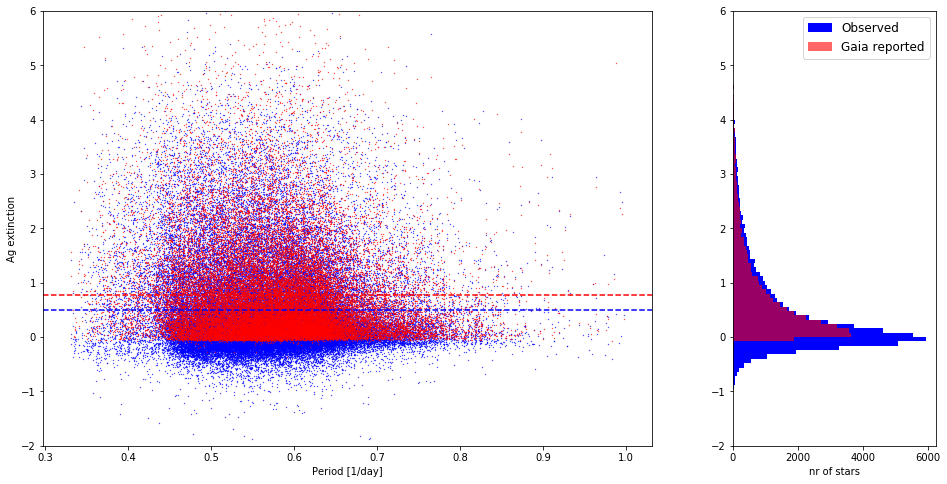

In [41]:
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(16,8))
ax0.scatter(data['pf'], data['Ag'], c='b', s=0.1)
ax0.scatter(data['pf'], data['g_absorption'], c='r', s=0.1)
ax0.axhline(y=np.mean(data['Ag']), c='b', ls="--")
ax0.axhline(y=np.mean(data['g_absorption']), c='r', ls="--")
ax0.set_ylim(-2,6); ax0.set_xlabel('Period [1/day]'); ax0.set_ylabel('Ag extinction')
ax1.hist(data['Ag'], orientation="horizontal", color='b', bins=100, range=(-2,6), label="Observed");
ax1.hist(data['g_absorption'], orientation="horizontal", color='r', bins=100, range=(-2,6), label="Gaia reported", fc=(1, 0, 0, 0.6));
ax1.set_ylim(-2,6); ax1.legend(); ax1.set_xlabel('nr of stars');

avg_Ag_diviation = np.mean( np.abs(data['g_absorption'] - data['Ag']) )
print(f"The average deviation in Ag between observations and Gaia, is {avg_Ag_diviation:.4f}.")

## 7.3 Quality cuts
Now, we have pulled down some ~60'000 RR Lyrae stars, basically without conditions. We should employ at least some moderate noise-filters.

Below we have employed two rather generous photometric quality cuts, as well as a requirement for the extinction to be above 0. This leaves us with around 28'000 stars. We can see from the plots that our concentration of stars with low extinction is far larger than reported in Gaia, where the density falls off towards 0. They have probably employed some more intelligent cuts or more sophisticated intrinsic model methods. Our density does however agree a whole lot towards higher extinction. Since we're only really interested in where the extinction is, we are going to assume this will not be a large problem.

We observe that the average difference in extinction is now approximately halved.

First filter reduces number of objects from 60317 to 55169.
Second filter further reduces number of objects to 44325.
Last filter finally reduces number of objects to 32084.
The average diviation in Ag between observations and Gaia, is 0.1645.


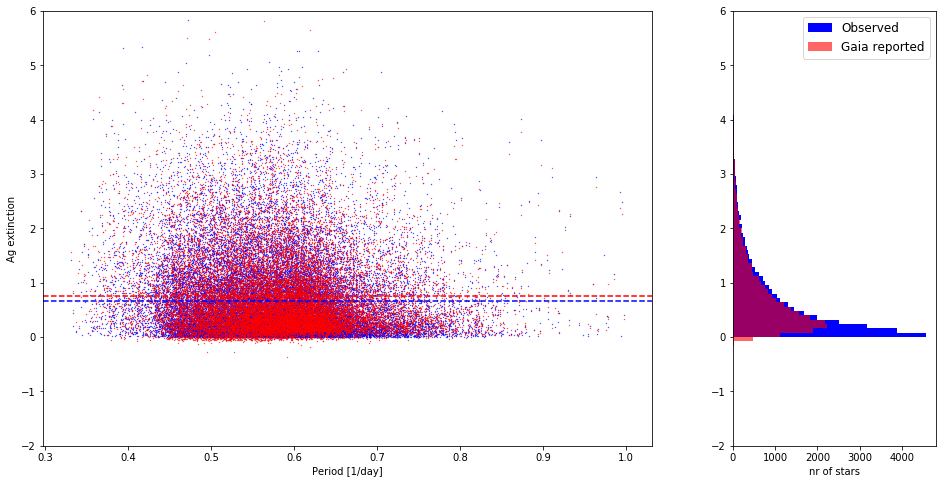

In [42]:
data_subset3 = data.copy()
data_subset3 = data_subset3[ (data_subset3['phot_g_mean_flux_over_error'] > 20) &\
                             (data_subset3['phot_rp_mean_flux_over_error'] > 10) &\
                             (data_subset3['phot_bp_mean_flux_over_error'] > 10)]
print(f"First filter reduces number of objects from {len(data)} to {len(data_subset3)}.")

data_subset3 = data_subset3[
    (data_subset3['phot_bp_rp_excess_factor'] < 1.3+0.06*(data_subset3['phot_bp_mean_mag']-data_subset3['phot_rp_mean_mag'])**2)&\
    (data_subset3['phot_bp_rp_excess_factor'] > 1.0+0.015*(data_subset3['phot_bp_mean_mag']-data_subset3['phot_rp_mean_mag'])**2)]

print(f"Second filter further reduces number of objects to {len(data_subset3)}.")

data_subset3 = data_subset3[data_subset3['Ag']>0]

print(f"Last filter finally reduces number of objects to {len(data_subset3)}.")

avg_Ag_diviation = np.mean( np.abs(data_subset3['g_absorption'] - data_subset3['Ag']) )
print(f"The average diviation in Ag between observations and Gaia, is {avg_Ag_diviation:.4f}.")

fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(16,8))
ax0.scatter(data_subset3['pf'], data_subset3['Ag'], c='b', s=0.1)
ax0.scatter(data_subset3['pf'], data_subset3['g_absorption'], c='r', s=0.1)
ax0.axhline(y=np.mean(data_subset3['Ag']), c='b', ls="--")
ax0.axhline(y=np.mean(data_subset3['g_absorption']), c='r', ls="--")
ax0.set_ylim(-2,6); ax0.set_xlabel('Period [1/day]'); ax0.set_ylabel('Ag extinction')
ax1.hist(data_subset3['Ag'], orientation="horizontal", color='b', bins=100, range=(-2,6), label="Observed");
ax1.hist(data_subset3['g_absorption'], orientation="horizontal", color='r', bins=100, range=(-2,6), label="Gaia reported", fc=(1, 0, 0, 0.6));
ax1.set_ylim(-2,6); plt.legend(); ax1.set_xlabel('nr of stars');



# 8. Mapmaking
We will now look plot a night-sky map of the Ag extinction we have calculated. Below we see such a map, in Galactic latitude and longitude. We can clearly see the dustgloud associated with the Milky Way, cutting across the $b=0$ plane. The lack of observed stars *on* the main galactic disk is also apparent. These were probably removed in quality cuts, or not included in the catalog at all, due to the immense difficulty of accurately measuring photometry in such dense areas of the night sky. We also see some large scale structures around $b=-40$,  $l=-75$. These might might be galaxies or other large-scale clusters of stars. Generally, the map is very non-uniform in its distribution, which isn't very surprising. The night sky doesn't have a uniform distribution of RR Lyrae stars (at least not in the Gaia database). Our quality cuts are also very discriminating against some areas, like the galactic disk.

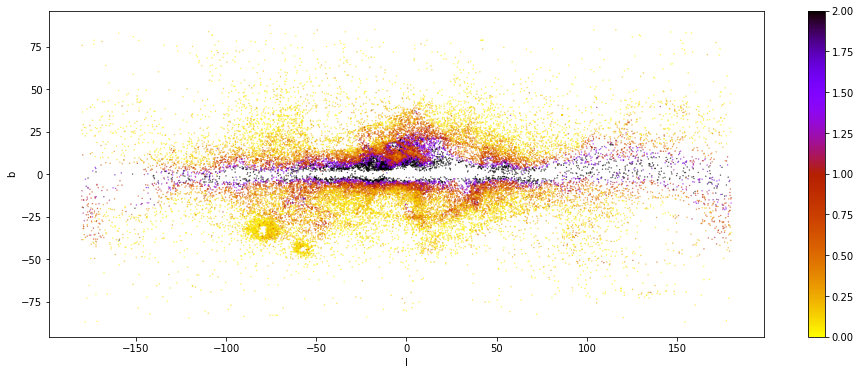

In [43]:
data_subset3['l2'] = data_subset3['l']
data_subset3['l2'] = [x if x < 180 else x-360 for x in data_subset3['l']]

plt.figure(figsize=(16,6))
plt.scatter(data_subset3['l2'], data_subset3['b'], c=data_subset3['Ag'], s=0.1, cmap='gnuplot_r', vmin=0, vmax=2)
plt.xlabel('l'); plt.ylabel('b'); plt.colorbar();

In [44]:
def Aitoff_projection(l, b):
    l, b = 2*np.pi/360*l, 2*np.pi/360*b
    alpha = np.arccos(np.cos(b)*np.cos(l/2))
    x = 2*np.cos(b)*np.sin(l/2)/np.sinc(alpha)
    y = np.sin(b)/np.sinc(alpha)
    return x, y

data_subset3['x_Aitoff'], data_subset3['y_Aitoff'] = Aitoff_projection(data_subset3['l2'], data_subset3['b'])

l_deg = data_subset3['l2'].values
b_deg = data_subset3['b'].values

## 8.1 Aitoff Projection and comparison to more complete maps

Below we have used the Aitoff Projection to map the resulting stars onto a more natural shape. We have also accessed a more complete dustmap using a Python dustmap module. In the first image below we have collected the reported extinction from this module at all point were we have located RR Lyrae stars. In the second image we see our own calculated extinction. The third image shows their absolute difference. The difference is small. Interestingly, it is almost entirely one-sided, with the catalog almost always reporting a higher extinction level, albeit small. 


We have used the $R_V=2.742$ value suggested for the SFD map in the dustmap module [documentation](https://dustmaps.readthedocs.io/en/latest/examples.html#getting-started), and collected from Table 6 of [Schlafly & Finkbeiner (2011)] (http://iopscience.iop.org/0004-637X/737/2/103/article#apj398709t6).

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


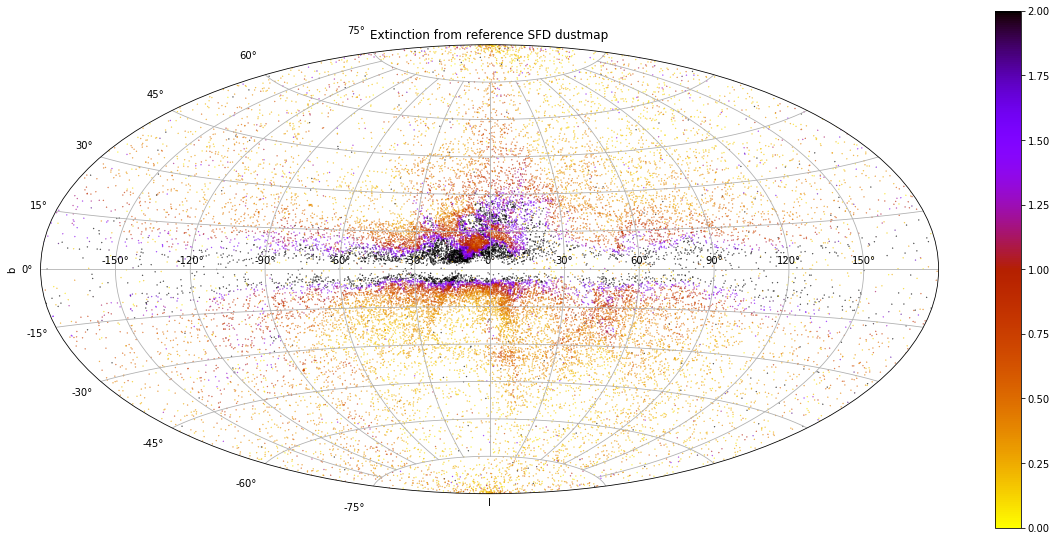

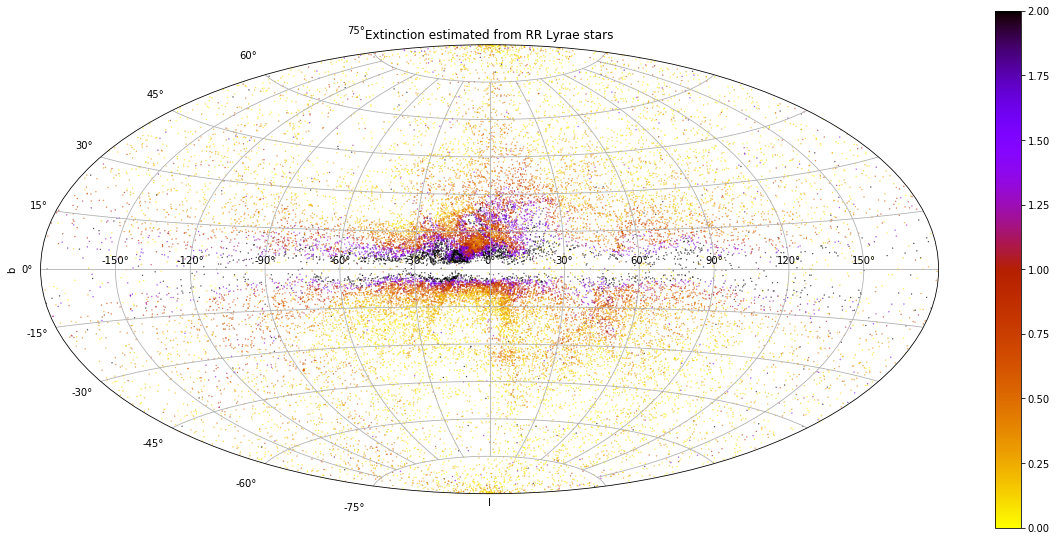

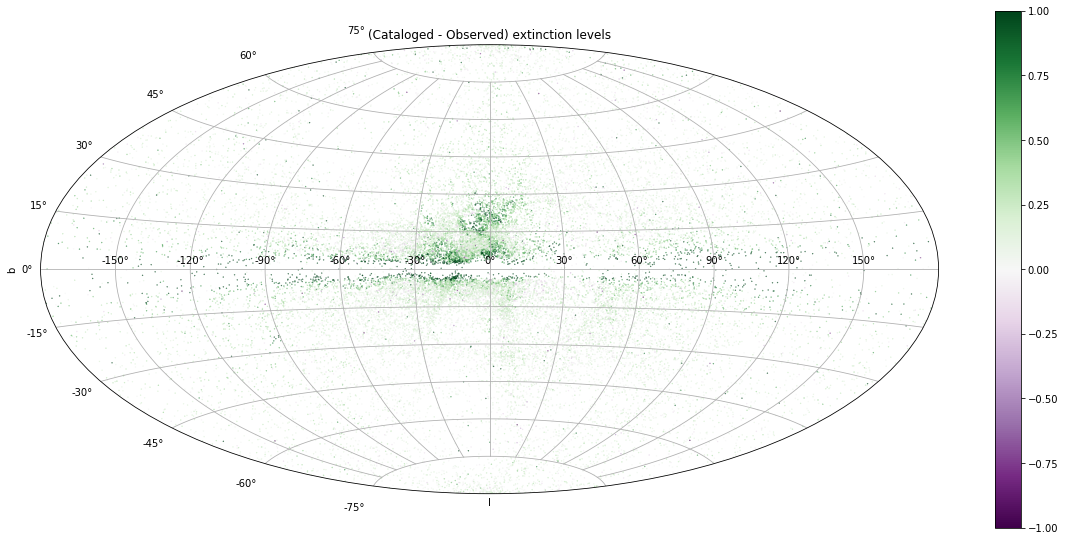

In [45]:
import dustmaps
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
dustmaps.sfd.fetch()

coords = SkyCoord(l_deg, b_deg, unit='deg', frame='galactic')
sfd = SFDQuery()
Av_dustmap = 2.742 * sfd(coords)

plt.figure(figsize=(16,8))
plt.subplot(111, projection="aitoff")
plt.grid(True); plt.tight_layout();
plt.scatter(data_subset3['x_Aitoff'], data_subset3['y_Aitoff'], c=Av_dustmap, s=0.1, cmap='gnuplot_r', vmin=0, vmax=2)
plt.xlabel('l'); plt.ylabel('b'); plt.title("Extinction from reference SFD dustmap"); plt.colorbar();

plt.figure(figsize=(16,8))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff")
plt.grid(True); plt.tight_layout();
plt.scatter(data_subset3['x_Aitoff'], data_subset3['y_Aitoff'], c=data_subset3['Ag'], s=0.1, cmap='gnuplot_r', vmin=0, vmax=2)
plt.xlabel('l'); plt.ylabel('b'); plt.title("Extinction estimated from RR Lyrae stars"); plt.colorbar();

plt.figure(figsize=(16,8))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff")
plt.grid(True); plt.tight_layout();
plt.scatter(data_subset3['x_Aitoff'], data_subset3['y_Aitoff'], c=(Av_dustmap - data_subset3['Ag']), s=0.1, cmap='PRGn', vmin=-1, vmax=1)
plt.xlabel('l'); plt.ylabel('b'); plt.title("(Cataloged - Observed) extinction levels"); plt.colorbar();

## 8.2 An actual dustmap
At last we will employ scipy's grid-interpolation algorithm to map all our point onto a raster image. This has its obvious flaws, as many points on the image lie far from any data-point, especially those in the center off, or far from, the Milky Way. It does however give a more natural feel to the map, as it takes the attention away from the RR Lyrae stars, and more clearly shows the dustclouds they reveal.

Below a interpolated raster image is plotted. Comparing to the much more complete dustmap from the Python module, plotted below, it looks fairly good, with the right general layout. It is, however, quite low resolutions, especially in the areas mentioned above. 

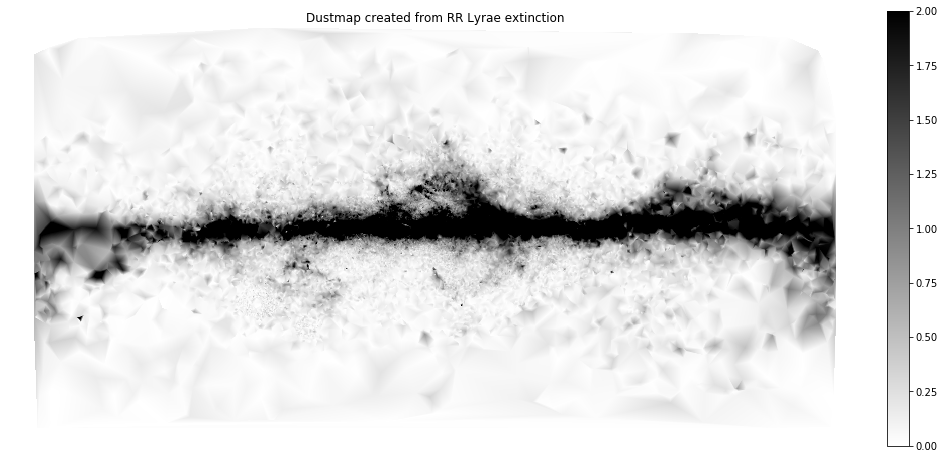

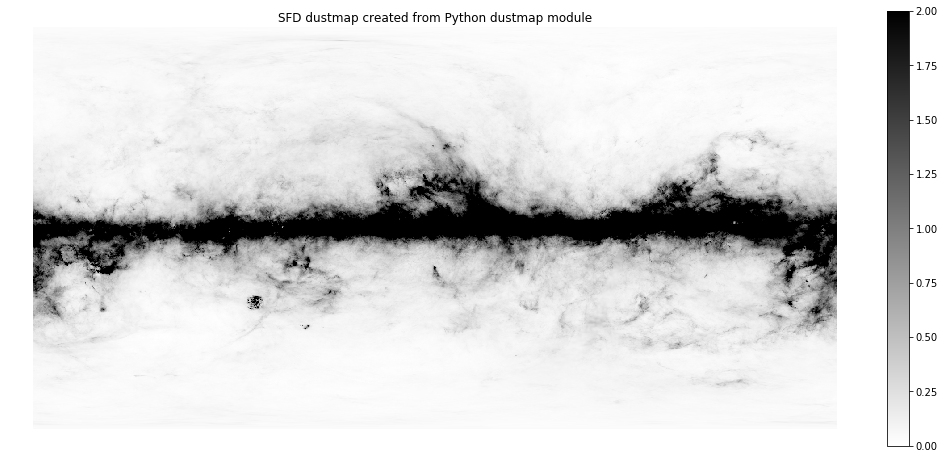

In [46]:
current_cmap = mpl.cm.get_cmap()
current_cmap.set_bad(color='black')

x = l_deg
y = b_deg
xy = np.array([*zip(x,y)])
z = data_subset3['Ag']
x_, y_ = np.linspace(x.min(), x.max(), 1600), np.linspace(y.min(), y.max(), 800)
xi, yi = np.meshgrid(x_, y_)
zi = scipy.interpolate.griddata(xy, z, (xi, yi), method='linear')

plt.figure(figsize=(18,8))
plt.imshow(
    zi,
    vmin=0,
    vmax=2.,
    origin='lower',
    interpolation='nearest',
    cmap='binary'
)
plt.axis('off'); plt.colorbar(); plt.title('Dustmap created from RR Lyrae extinction');

l = np.arange(-180, 180, 0.2)
b = np.arange(-90, 90, 0.2)
l, b = np.meshgrid(l, b)
coords = SkyCoord(l, b, unit='deg', frame='galactic')
Av_dustmap = 2.742 * sfd(coords)
plt.figure(figsize=(18,8))
plt.imshow(
    Av_dustmap,
    vmin=0,
    vmax=2.,
    origin='lower',
    interpolation='nearest',
    cmap='binary'
);
plt.axis('off'); plt.colorbar(); plt.title('SFD dustmap created from Python dustmap module');

# Future Work
Although I'm very pleased with the final result, there are some areas of this lab that could have been more thoroughly exlored. Especially the MCMC sampling and statistical groundwork for our model fit deserves more rigorous work. I would have liked to have done more convergence-checking, explored the statistical background of the MCMC in greated detail, and perhaps even included an informed prior. The model could also have included other parameters, like metallicity.

The quality cuts done in the final model could also have been done with more care. It is a shame that all the stars on the galatic disk were removed in this process.